In [66]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
df = pd.read_table(r'/home/agastya/Documents/Praxis - Subjects/Marketing Analytics/End_Term_Assignment/purchases.txt', \
                  names=['customer_id', 'purchase_amount', 'date_of_purchase'], parse_dates=[2])

In [3]:
df

,customer_id,purchase_amount,date_of_purchase
0,760,25.0,2009-11-06
1,860,50.0,2012-09-28
2,1200,100.0,2005-10-25
3,1420,50.0,2009-07-09
4,1940,70.0,2013-01-25
...,...,...,...
51238,163230,30.0,2011-11-12
51239,154410,100.0,2013-11-15
51240,189270,30.0,2014-12-23
51241,173810,30.0,2015-05-28


In [ ]:
#Cluster graphs (descriptive stats using histograms etc..)

In [4]:
df.dtypes

customer_id                  int64
purchase_amount            float64
date_of_purchase    datetime64[ns]
dtype: object

# RFM Analysis #

### Recency ###
#### Group by customer, then subtract the current date (which will be the most recent date) from the customers most recent purchase date ####


### Frequency ###
#### On the grouped dataset, find the number of times a customer has visited the store ####


### Monetary Value ###
#### On the grouped dataset, find the average purchase amount of each customer ####

In [5]:
current_date = df['date_of_purchase'].max()

In [6]:
current_date # 2015-12-31

Timestamp('2015-12-31 00:00:00')

In [7]:
customer_grouped = df.groupby('customer_id').agg\
(purchase_date=('date_of_purchase', 'max'), purchase_count=('purchase_amount', 'count'), purchase_average=('purchase_amount', 'mean'))

In [8]:
customer_grouped.head()

,purchase_date,purchase_count,purchase_average
customer_id,,,
10,2005-07-08,1,30.000000
80,2015-01-23,7,71.428571
90,2013-12-04,10,115.800000
120,2012-03-01,1,20.000000
130,2007-11-14,2,50.000000


In [9]:
# Calculate the recency in days
customer_grouped['days_since_last_purchase'] = customer_grouped['purchase_date'].map(lambda x: (current_date-x).days)

In [10]:
# Drop the purchase date column
customer_grouped = customer_grouped.drop('purchase_date', axis=1)

In [11]:
# To sort it, to match RFM
customer_grouped = customer_grouped.reindex(columns=['days_since_last_purchase', 'purchase_count', 'purchase_average'])

In [12]:
customer_grouped

,days_since_last_purchase,purchase_count,purchase_average
customer_id,,,
10,3828,1,30.000000
80,342,7,71.428571
90,757,10,115.800000
120,1400,1,20.000000
130,2969,2,50.000000
...,...,...,...
263820,0,1,10.000000
263870,134,1,50.000000
263880,33,1,20.000000


## Clustering ##

Use K-Means

In [13]:
from sklearn.cluster import KMeans
import seaborn as sb
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [14]:
ss_customers = StandardScaler()
std_cust_data = ss_customers.fit_transform(customer_grouped)

In [15]:
kmc = KMeans(6, n_init=100, random_state=1234)
kmc.fit(std_cust_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=1234, tol=0.0001, verbose=0)

In [16]:
centroids = pd.DataFrame(ss_customers.inverse_transform(kmc.cluster_centers_), columns=['Recency',  'Frequency', 'Monetary'])

In [17]:
centroids

,Recency,Frequency,Monetary
0,659.301262,1.563164,45.629433
1,2566.352610,1.521102,36.351908
2,229.632367,11.579046,62.548991
3,1310.477273,2.113636,2486.192630
4,480.210544,5.604587,53.637119
5,840.953488,2.604651,817.424632


In [18]:
np.unique(kmc.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32),
 array([8003, 6208, 1069,   44, 2921,  172]))

**Important groups:**

**Cluster 1** ***229.632367        11.579046 	      62.548991***- 
**Name - The Current Customers**

1. The most recent group, consists of buyers who are still actively coming to the store (active customer base)
2. They are the most frequent, i.e. loyal customers.
3. Actionable, since their purchase averages aren't much
4. They buy quite a few items, which means that they do their periodic shopping from here. A huge opportunity, therefore, to upsell and cross-sell, since the loyalty is already there.
5. 

**Cluster 2** ***480.210544 	      5.604587 	      53.637119***
**Name - The (almost) lapsed customers**

1. The next most recent group
2. They may still be attracted to the store by promotions
3. Used to spend reasonably big amounts when visiting the store
4. Not so old that they cannot be brought back to the store
5. 

## Marketing Actions
#### Target and derive more business

**Cluster 1**
1. In store promotions
2. Loyalty benefits - loyalty points, special discounts and sales, special services (free home delivery, valet parking)
3. Upselling - Combo Offers etc.. and Cross Selling (HOW??)
4. Focus on Customer Support and services
5. 

**Cluster 2**
1. Targeted Advertising (SMS, Email, FB, Inst etc..)
2. Habit forming??
3. Attract them by discounts, free gifts, other offers etc..
4. Focus on their experience
5. More variety of goods, offer them something they will not get anywhere else
6. Have special discount days, and communicate it to them
7. 


In [139]:
# EDA for clusters

In [142]:
customer_grouped['cluster'] = kmc.labels_

In [164]:
our_clusters = customer_grouped[(customer_grouped['cluster']==2) | (customer_grouped['cluster']==4)]

In [168]:
our_clusters.nunique()

days_since_last_purchase     654
purchase_count                31
purchase_average            1012
cluster                        2
dtype: int64

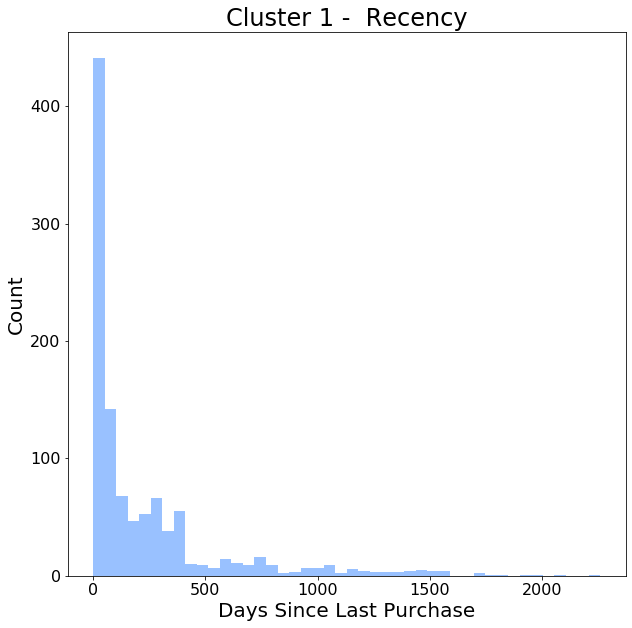

In [238]:
fig = plt.figure(figsize=(10, 10))
sb.distplot(customer_grouped[customer_grouped['cluster']==2]['days_since_last_purchase'], kde=False, color='#0066ff')
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlabel('Days Since Last Purchase', size=20)
plt.ylabel('Count', size=20)
plt.title('Cluster 1 -  Recency', size=24)
plt.savefig('km_cluster_1_recency.png', dpi=300, bbox_inches='tight')

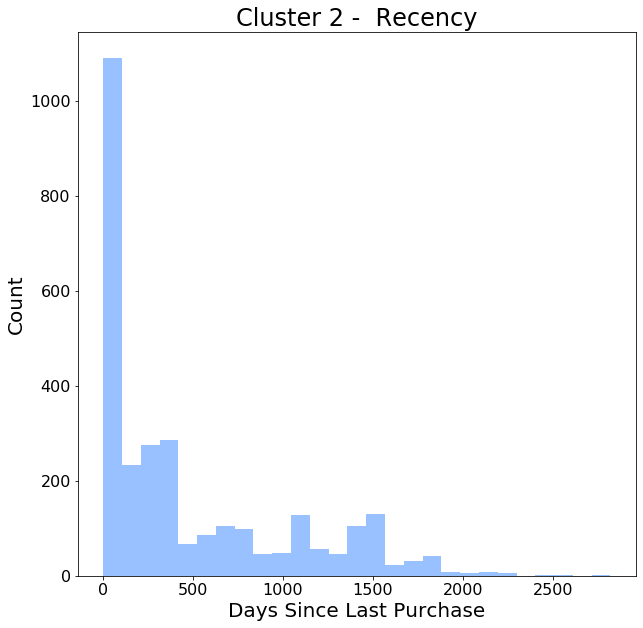

In [239]:
fig = plt.figure(figsize=(10, 10))
sb.distplot(customer_grouped[customer_grouped['cluster']==4]['days_since_last_purchase'], kde=False, color='#0066ff')
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlabel('Days Since Last Purchase', size=20)
plt.ylabel('Count', size=20)
plt.title('Cluster 2 -  Recency', size=24)
plt.savefig('km_cluster_2_recency.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Cluster 2 -  Average Purchase Value')

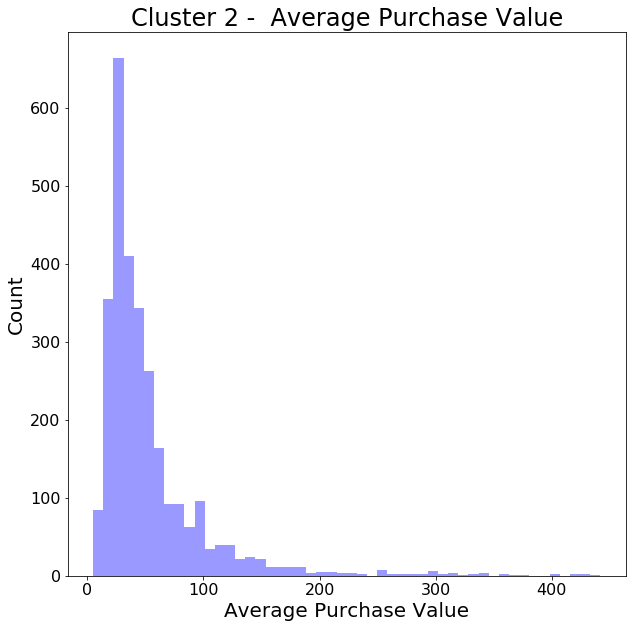

In [236]:
fig = plt.figure(figsize=(10, 10))
sb.distplot(customer_grouped[customer_grouped['cluster']==4]['purchase_average'], kde=False, color='blue')
plt.xticks(size=16)
plt.yticks(size=16)
plt.xlabel('Average Purchase Value', size=20)
plt.ylabel('Count', size=20)
plt.title('Cluster 2 -  Average Purchase Value', size=24)
plt.savefig('km_cluster_2_monetary.png', dpi=300, bbox_inches='tight')

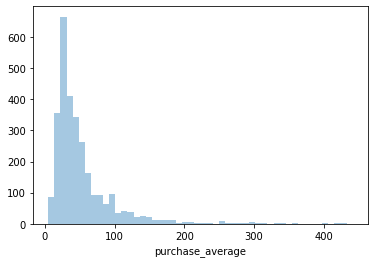

In [178]:
sb.distplot(customer_grouped[customer_grouped['cluster']==4]['purchase_average'], kde=False)

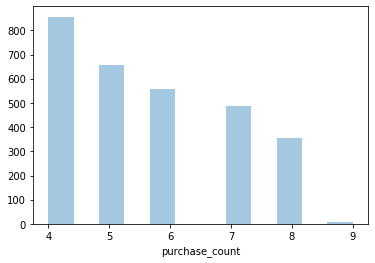

In [179]:
sb.distplot(customer_grouped[customer_grouped['cluster']==4]['purchase_count'], kde=False)

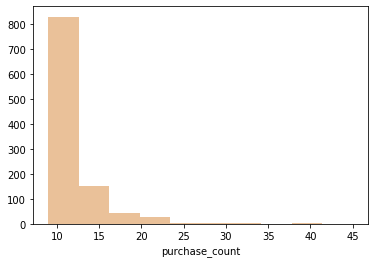

In [228]:
sb.distplot(customer_grouped[customer_grouped['cluster']==2]['purchase_count'], kde=False,\
            bins=10, color='#cc6600')

In [173]:
our_clusters

,days_since_last_purchase,purchase_count,purchase_average,cluster
customer_id,,,,
80,342,7,71.428571,4
90,757,10,115.800000,2
240,462,4,16.250000,4
290,786,7,77.857143,4
330,1166,5,34.000000,4
...,...,...,...,...
228060,419,9,20.000000,2
229180,22,4,125.000000,4
231590,358,4,30.000000,4


/home/agastya/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Legend does not support 2 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  
/home/agastya/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Legend does not support 4 instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  


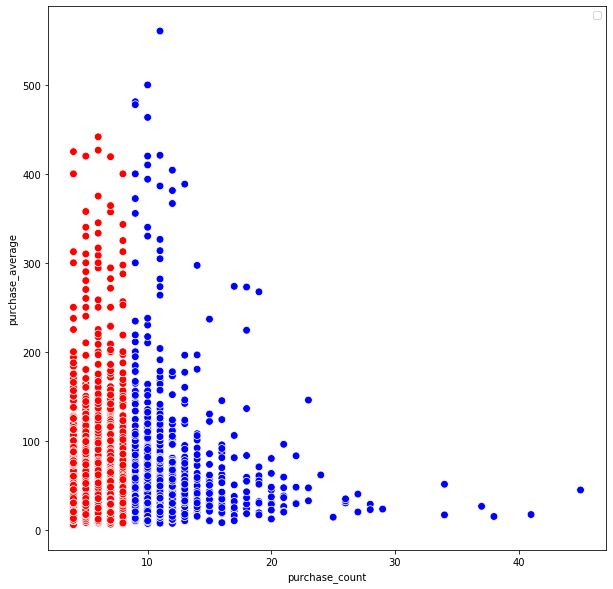

In [231]:
# DO THIS
fig = plt.figure(figsize=(10, 10))
sb.scatterplot(x='purchase_count', y='purchase_average', hue='cluster', data=our_clusters, s=60, \
               palette={2:'#0000ff', 4:'#ff0000'}, legend=False)

plt.legend(loc='upper right', handles=(2, 4), labels=('Cluster 2', 'Cluster 4'))

### Scoring Each Customer ###

### Weights to assign: ###

Since it is a retail store (like Landmark), the most important factor is the recency, followed by monetary value, followed by frequency. 

The main aim would be to improve the frequency, which would obviously improve recency.

For recency, instead of having different ranks based on the day count, we could perhaps split them up into groups (say 3 months, 6 months, 12 months etc..) Then, rank based on that.

All customers who last came within the past 1 year should be given equal importance for recency. Then, they should be ranked based on their monetary value and the frequency.


Recency - Score of 0 if the customer last came more than 3 years ago, assuming them to be lapsed 

For the others, use a min-max standardization, then see

Frequency - Again, use a min-max standardization, then see

Monetary Value - Min-max standardization again

In [19]:
# 360, since it's easy to bin
recent_customers = customer_grouped[customer_grouped['days_since_last_purchase']<360*3] 

In [20]:
customer_grouped.shape, recent_customers.shape

((18417, 3), (9249, 3))

In [21]:
# Create bins for recency
bins = [90*i for i in range(14)]

recency_cuts = pd.cut(recent_customers['days_since_last_purchase'], bins, include_lowest=True)

In [22]:
recency_cuts

customer_id
80        (270.0, 360.0]
90        (720.0, 810.0]
240       (450.0, 540.0]
290       (720.0, 810.0]
480       (-0.001, 90.0]
               ...      
263820    (-0.001, 90.0]
263870     (90.0, 180.0]
263880    (-0.001, 90.0]
263890    (-0.001, 90.0]
264200    (-0.001, 90.0]
Name: days_since_last_purchase, Length: 9249, dtype: category
Categories (13, interval[float64]): [(-0.001, 90.0] < (90.0, 180.0] < (180.0, 270.0] < (270.0, 360.0] ... (810.0, 900.0] < (900.0, 990.0] < (990.0, 1080.0] < (1080.0, 1170.0]]

In [23]:
recent_customers_scaled = MinMaxScaler((1, 10)).fit_transform(recent_customers)

In [24]:
recent_customers_scaled = pd.DataFrame(recent_customers_scaled, columns=recent_customers.columns,\
                                      index=recent_customers.index)

In [25]:
recent_customers_scaled['days_since_last_purchase'] = recency_cuts

In [26]:
recent_customers_scaled

,days_since_last_purchase,purchase_count,purchase_average
customer_id,,,
80,"(270.0, 360.0]",2.227273,1.133005
90,"(720.0, 810.0]",2.840909,1.221846
240,"(450.0, 540.0]",1.613636,1.022525
290,"(720.0, 810.0]",2.227273,1.145876
480,"(-0.001, 90.0]",3.250000,1.111791
...,...,...,...
263820,"(-0.001, 90.0]",1.000000,1.010011
263870,"(90.0, 180.0]",1.000000,1.090100
263880,"(-0.001, 90.0]",1.000000,1.030033


In [27]:
r_rank = recent_customers_scaled['days_since_last_purchase'].rank(method='dense', ascending=False)
f_rank = recent_customers_scaled['purchase_count'].rank(method='dense')
m_rank = recent_customers_scaled['purchase_average'].rank(method='dense')

In [28]:
ranked_df = pd.DataFrame([r_rank, f_rank, m_rank]).transpose()

In [29]:
weights = [.2, .4, .6]    #R, F, M

In [30]:
ranks = ranked_df.multiply(weights).sum(axis=1).sort_values()

In [31]:
customer_grouped.loc[ranks.index].iloc[:20]

,days_since_last_purchase,purchase_count,purchase_average
customer_id,,,
197010,964,1,5.0
197650,960,1,5.0
202330,874,1,5.0
203490,820,1,5.0
206820,798,1,5.0
209010,793,1,5.0
209160,792,1,5.0
206010,800,1,5.0
208240,797,1,5.0


In [32]:
customer_grouped.loc[ranks.index].iloc[-20:]

,days_since_last_purchase,purchase_count,purchase_average
customer_id,,,
212920,743,1,2000.000000
145810,665,1,2000.000000
222460,581,1,2000.000000
260020,61,1,1862.000000
181880,579,3,2000.000000
234330,365,1,2200.000000
212980,36,3,2166.666667
246530,226,1,2500.000000
215930,691,1,3000.000000


In [33]:
df['month'] = df['date_of_purchase'].map(lambda x: x.month)

In [34]:
df

,customer_id,purchase_amount,date_of_purchase,month
0,760,25.0,2009-11-06,11
1,860,50.0,2012-09-28,9
2,1200,100.0,2005-10-25,10
3,1420,50.0,2009-07-09,7
4,1940,70.0,2013-01-25,1
...,...,...,...,...
51238,163230,30.0,2011-11-12,11
51239,154410,100.0,2013-11-15,11
51240,189270,30.0,2014-12-23,12
51241,173810,30.0,2015-05-28,5


In [35]:
df.groupby('month').agg(['mean', 'count']).drop('customer_id', axis=1)

purchase_amount       
                 mean  count
month                       
1           50.291987   1515
2           51.742945   1562
3           51.568173   3278
4           50.669610   4234
5           87.074370   3206
6           70.355205   3126
7           52.290516   3159
8           48.838925   1553
9           68.749223   2768
10          54.430402   5570
11          55.052787   6384
12          71.782569  14888

In [36]:
recent_customers.loc[ranks.index].iloc[-1500:, :].describe() 
# Good in everything, but we need to get them to drop in more

,days_since_last_purchase,purchase_count,purchase_average
count,1500.000000,1500.000000,1500.000000
mean,263.088000,4.234000,230.747056
std,293.041262,3.664814,402.804615
min,0.000000,1.000000,79.090909
25%,24.750000,1.000000,100.000000
50%,127.000000,3.000000,111.375000
75%,402.000000,6.000000,180.000000
max,1076.000000,22.000000,4500.000000


**Name - The spendthrifts**??
Ideas to increase frequency:

1. Have more sales, and happy days etc..
2. Send personalized emails, messages, to attract customers more often
3. Time bound coupons
4. Points that need to be redeemed within a certain time frame (loyalty points)
5. Book and Music Launches, other events
6. Personalized discounts for birthdays, anniversaries etc..


In [37]:
# Need to primarily increase average purchase value (by upselling). Getting them to come more will be an added bonus
recent_customers.loc[ranks.index].iloc[-3000:-1500, :].describe()

,days_since_last_purchase,purchase_count,purchase_average
count,1500.000000,1500.000000,1500.000000
mean,264.799333,4.290667,60.524986
std,297.225743,3.648249,8.344943
min,0.000000,1.000000,49.230769
25%,29.000000,1.000000,54.000000
50%,107.000000,3.000000,60.000000
75%,414.000000,6.000000,65.000000
max,1076.000000,34.000000,80.250000


All the frequency items will also apply here. Focusing on only increasing the monetary value:

1. Provide extra services (eg. a video game kiosk etc..) that makes people stay longer
2. Cross-Selling (but how?). Keep items in the store that complement other items. Have combo offers etc.
3. Staff training, better interaction with customers, to sell more
4. Keep more variety/merchandise, to increase sales
5. Upsell (how??) 


In [38]:
# Need to attract them back to the store, and increase their spending

recent_customers.loc[ranks.index].iloc[-4500:-3000, :].describe()

,days_since_last_purchase,purchase_count,purchase_average
count,1500.000000,1500.000000,1500.000000
mean,366.802000,3.618000,44.877075
std,321.963307,3.606209,4.127308
min,0.000000,1.000000,36.750000
25%,58.000000,1.000000,40.000000
50%,292.000000,2.000000,45.000000
75%,642.250000,5.000000,50.000000
max,1079.000000,45.000000,50.000000


7. Provide extra services (eg. a video game kiosk,  etc..


In [39]:
recent_customers.loc[ranks.index].iloc[-6000:-4500, :].describe()

,days_since_last_purchase,purchase_count,purchase_average
count,1500.000000,1500.000000,1500.000000
mean,206.713333,4.216667,31.744617
std,248.545918,3.728314,2.417575
min,0.000000,1.000000,28.571429
25%,35.000000,2.000000,30.000000
50%,79.000000,3.000000,30.000000
75%,292.250000,6.000000,33.392857
max,1076.000000,28.000000,37.500000


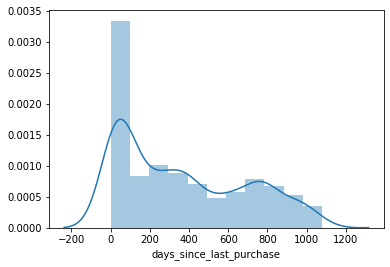

In [40]:
sb.distplot(recent_customers.loc[ranks.index].iloc[-4500:-3000, :]['days_since_last_purchase'])

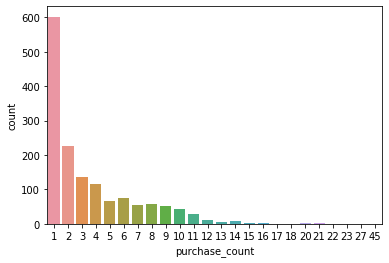

In [41]:
sb.countplot(recent_customers.loc[ranks.index].iloc[-4500:-3000, :]['purchase_count'])

In [42]:
recent_customers.loc[ranks.index].iloc[-1000:, :].describe()

,days_since_last_purchase,purchase_count,purchase_average
count,1000.000000,1000.000000,1000.000000
mean,219.579000,4.469000,299.053567
std,268.810455,3.582998,478.980044
min,0.000000,1.000000,98.333333
25%,14.000000,1.000000,111.437500
50%,78.000000,3.000000,150.000000
75%,365.000000,7.000000,236.875000
max,1070.000000,19.000000,4500.000000


In [43]:
recent_customers.describe()

,days_since_last_purchase,purchase_count,purchase_average
count,9249.000000,9249.000000,9249.000000
mean,336.249000,3.742026,67.392735
std,322.143841,3.627653,177.985442
min,0.000000,1.000000,5.000000
25%,54.000000,1.000000,28.333333
50%,245.000000,2.000000,36.000000
75%,610.000000,5.000000,60.000000
max,1079.000000,45.000000,4500.000000


### EDA

**Only Working on the recent data (from 2013 onwards) 

In [86]:
df['month_name'] = df['date_of_purchase'].map(lambda x: x.month_name())

In [87]:
df['month'] = df['date_of_purchase'].map(lambda x: x.month)

In [88]:
df['year'] = df['date_of_purchase'].map(lambda x: x.year)

In [89]:
recent_df = df[df['date_of_purchase']>'01-01-2013']

In [125]:
monthly_avg_sales = recent_df.groupby('month').agg({'purchase_amount':'mean', 'customer_id':'count'})

In [127]:
month_names = ['January','February','March','April','May','June','July','August','September','October','November','December']

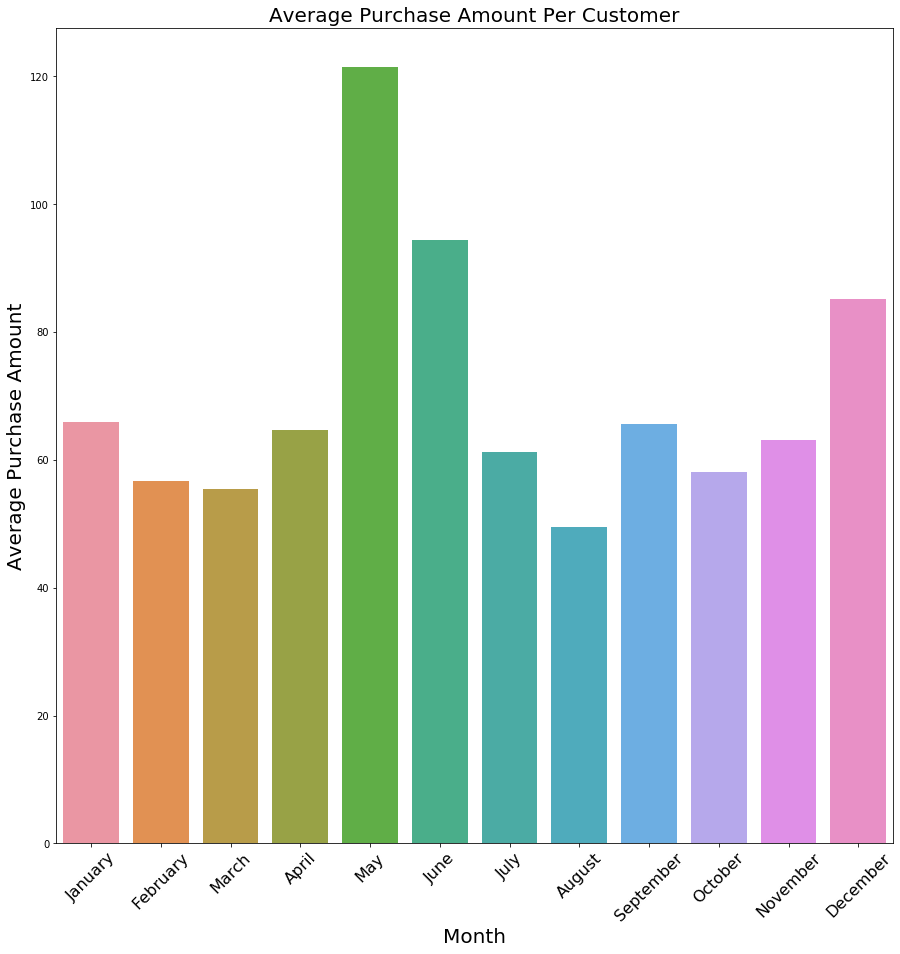

In [128]:
fig = plt.figure(figsize=(15, 15))
sb.barplot(monthly_avg_sales.index, monthly_avg_sales['purchase_amount'])
plt.xticks(np.arange(12), labels= month_names, rotation=45, size=16)
plt.xlabel('Month', size=20)
plt.ylabel('Average Purchase Amount', size=20)
plt.title('Average Purchase Amount Per Customer', size=20)
# plt.savefig('monthly_purchases.png', dpi=300, bbox_inches='tight')
plt.show()


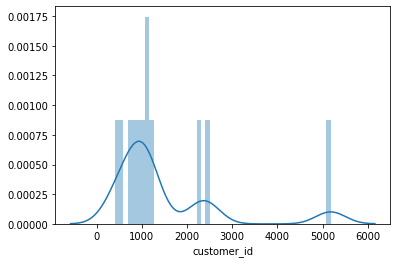

In [133]:
sb.distplot(monthly_avg_sales['customer_id'], bins=50)

In [137]:
df.describe()

,customer_id,purchase_amount,month,year
count,51243.000000,51243.000000,51243.000000,51243.000000
mean,108934.547938,62.337195,8.395761,2010.869699
std,67650.610139,156.606801,3.526799,2.883072
min,10.000000,5.000000,1.000000,2005.000000
25%,57720.000000,25.000000,5.000000,2009.000000
50%,102440.000000,30.000000,10.000000,2011.000000
75%,160525.000000,60.000000,12.000000,2013.000000
max,264200.000000,4500.000000,12.000000,2015.000000


In [138]:
recent_df.describe()

,customer_id,purchase_amount,month,year
count,17848.000000,17848.000000,17848.000000,17848.000000
mean,153435.496414,73.547149,8.543254,2014.015968
std,71948.774090,195.857548,3.493517,0.823550
min,80.000000,5.000000,1.000000,2013.000000
25%,97280.000000,30.000000,5.000000,2013.000000
50%,172390.000000,40.000000,10.000000,2014.000000
75%,210470.000000,60.000000,12.000000,2015.000000
max,264200.000000,4500.000000,12.000000,2015.000000


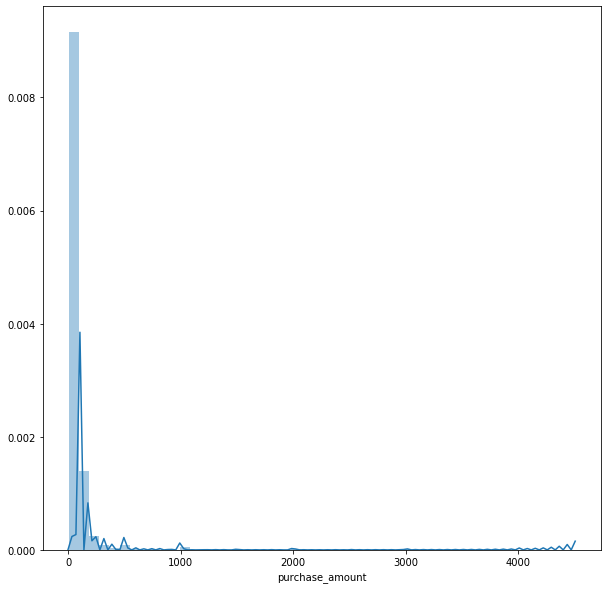

In [136]:
plt.figure(figsize=(10, 10))
sb.distplot(recent_df['purchase_amount'])